In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [3]:
import sys
sys.path.insert(0, '../.')

In [4]:
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
from Trainer import *
from evaluation.evaluate import *

In [5]:
base_path = '../../../Data'

In [14]:
import numpy as np
import cv2
from data.data_utils.velodyne_points import *
from utils.utils import *
import math
import os
import random

from data.data_utils.reader import *
from data.data_utils.target_utils import *
from data.data_utils.fv_utils import *
from data.dataset_loader import *


class DetectionDatasetLoader(DatasetLoader):

    def _defaults(self, **kwargs):
        defaults = {
            'image_size': (370, 1224),
            'lidar_size': (512, 448, 40), 
            'anchors': np.array([3.9, 1.6, 1.5])
        }
        for k in kwargs:
            if k in defaults:
                defaults[k] = kwargs[k]
        return defaults
        

    def _init_generator(self):

        list_files = list(map(lambda x: x.split('.')[0], os.listdir(self.base_path+'/data_object_image_3/training/image_3')))
        random.seed(self.random_seed)
        random.shuffle(list_files)

        camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
        lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
        label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
        calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
        if self.num_samples is None:
            ln = int(len(list_files) * self.training_per)
            final_sample = len(list_files)
        else:
            ln = int(self.num_samples * self.training_per)
            final_sample = self.num_samples
        
        if self.training:
            self.list_camera_paths = camera_paths[:ln]
            self.list_lidar_paths = lidar_paths[:ln]
            self.list_label_paths = label_paths[:ln]
            self.list_calib_paths = calib_paths[:ln]
        else:
            self.list_camera_paths = camera_paths[ln:final_sample]
            self.list_lidar_paths = lidar_paths[ln:final_sample]
            self.list_label_paths = label_paths[ln:final_sample]
            self.list_calib_paths = calib_paths[ln:final_sample]

        augment = self.training
        return self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=augment, 
                                    augment_rotate=augment,
                                    negative_samples=augment,
                                    training=self.training)
                    
    def reset_generator(self):
        augment = self.training
        self.generator = self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=augment, 
                                    augment_rotate=augment,
                                    negative_samples=augment,
                                    training=self.training)
        

    def get_next(self, batch_size=1):
        camera_tensors = []
        lidar_tensors = []
        fv_velo_tensors = []
        label_tensors = []
        Tr_velo_to_cams = []
        R0_rects = []
        P3s = [] 
        shift_hs = []
        shift_ws = [] 

        for _ in range(batch_size):
            camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = list(next(self.generator))
            camera_tensors.append(camera_tensor)
            lidar_tensors.append(lidar_tensor)
            label_tensors.append(label_tensor)
            Tr_velo_to_cams.append(Tr_velo_to_cam)
            R0_rects.append(R0_rect)
            P3s.append(P3)
            shift_hs.append(shift_h)
            shift_ws.append(shift_w)

        camera_tensors = np.array(camera_tensors)
        lidar_tensors = np.array(lidar_tensors)
        label_tensors = np.array(label_tensors)
        
        Tr_velo_to_cams = np.array(Tr_velo_to_cams)
        R0_rects = np.array(R0_rects)
        P3s = np.array(P3s)
        shift_hs = np.array(shift_hs)
        shift_ws = np.array(shift_hs)
        return (camera_tensors, lidar_tensors, label_tensors, Tr_velo_to_cams, R0_rects, P3s, shift_hs, shift_ws)


    def __data_generator(self, base_path, image_size, lidar_size, anchors, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                        augment_translate=False, augment_rotate=False, negative_samples=False, training=True):

#         if training:
#             value = random.randint(0, 50)
#             random.seed(value)
#             random.shuffle(list_camera_paths)
#             random.seed(value)
#             random.shuffle(list_lidar_paths)
#             random.seed(value)
#             random.shuffle(list_label_paths)
#             random.seed(value)
#             random.shuffle(list_calib_paths)

        for camera_path, lidar_path, label_path, calib_path in zip(list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths):
                camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                h, w, _ = cv2.imread(camera_path).shape
                lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w)
                velo_front_view = read_pc_fv(calib_path, lidar_path)
                _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w)
                label = get_target(label, directions,  anchors=anchors)
                camera_image = camera_image / 255.
                lidar_image = lidar_image / 255.
                yield(camera_image, lidar_image, label,
                            np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                            np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                            np.array(P3).reshape((3, 4)), 
                            np.array([shift_h]), 
                            np.array([shift_w])
                            )

                if augment_rotate:
                        translate_x = 0
                        translate_y = 0
                        ang = random.randint(-5, 5)
                    
                        camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                        h, w, _ = cv2.imread(camera_path).shape
                        lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y)
                        _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w, translate_x=translate_x, translate_y=translate_y, ang=ang)
                        label = get_target(label, directions,  anchors=anchors)
                        camera_image = camera_image / 255.
                        lidar_image = lidar_image / 255.
                        yield(camera_image, lidar_image, label,
                                    np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                                    np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                                    np.array(P3).reshape((3, 4)), 
                                    np.array([shift_h]), 
                                    np.array([shift_w])
                                    )

                if augment_translate:
                        translate_x = random.randint(-5, 5)
                        translate_y = random.randint(-5, 5)
                        translate_z = random.random() - 0.5
                        ang = 0
                        
                        camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                        h, w, _ = cv2.imread(camera_path).shape
                        lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y, translate_z=translate_z)
                        _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w, translate_x=translate_x, translate_y=translate_y, translate_z=-translate_z, ang=ang)
                        label = get_target(label, directions,  anchors=anchors)
                        camera_image = camera_image / 255.
                        lidar_image = lidar_image / 255.
                        yield(camera_image, lidar_image, label,
                                    np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                                    np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                                    np.array(P3).reshape((3, 4)), 
                                    np.array([shift_h]), 
                                    np.array([shift_w])
                                    )

                if augment_rotate and augment_translate:
                        translate_x = random.randint(-5, 5)
                        translate_y = random.randint(-5, 5)
                        translate_z = random.random() - 0.5
                        ang = random.randint(-5, 5)
                    
                        camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                        h, w, _ = cv2.imread(camera_path).shape
                        lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y, translate_z=translate_z)
                        _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w, translate_x=translate_x, translate_y=translate_y, translate_z=-translate_z, ang=ang)
                        label = get_target(label, directions,  anchors=anchors)
                        camera_image = camera_image / 255.
                        lidar_image = lidar_image / 255.
                        yield(camera_image, lidar_image, label,
                                    np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                                    np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                                    np.array(P3).reshape((3, 4)), 
                                    np.array([shift_h]), 
                                    np.array([shift_w])
                                    )


                        translate_x = random.randint(-5, 5)
                        translate_y = random.randint(-5, 5)
                        translate_z = random.random() - 0.5
                        ang = random.randint(-15, -5)
                    
                        camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                        h, w, _ = cv2.imread(camera_path).shape
                        lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y, translate_z=translate_z)
                        _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w, translate_x=translate_x, translate_y=translate_y, translate_z=-translate_z, ang=ang)
                        label = get_target(label, directions,  anchors=anchors)
                        camera_image = camera_image / 255.
                        lidar_image = lidar_image / 255.
                        yield(camera_image, lidar_image, label,
                                    np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                                    np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                                    np.array(P3).reshape((3, 4)), 
                                    np.array([shift_h]), 
                                    np.array([shift_w])
                                    )


                        translate_x = random.randint(-5, 5)
                        translate_y = random.randint(-5, 5)
                        translate_z = random.random() - 0.5
                        ang = random.randint(5, 15)
                    
                        camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                        h, w, _ = cv2.imread(camera_path).shape
                        lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y, translate_z=translate_z)
                        _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w, translate_x=translate_x, translate_y=translate_y, translate_z=-translate_z, ang=ang)
                        label = get_target(label, directions,  anchors=anchors)
                        camera_image = camera_image / 255.
                        lidar_image = lidar_image / 255.
                        yield(camera_image, lidar_image, label,
                                    np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                                    np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                                    np.array(P3).reshape((3, 4)), 
                                    np.array([shift_h]), 
                                    np.array([shift_w])
                                    )


                        




In [15]:
def read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations)
    # print(z_range)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]
    
    print(dimension_height)
    print(dimension_width)
    print(dimension_length)
    
    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, translate_z])
#         location_x -= translate_x
#         location_y -= translate_y
#         location_z -= translate_z

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac+(-b[4][2]+z_range[1])*z_fac)**2)

      
    for i in range(len(locations)):
        if angles[i] < 0:
            angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)
    print(output)
    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions


In [16]:
list_files2 = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files2)
ln = int(len(list_files2) * 0.5)
list_files2= list_files2[:ln]

In [17]:
i_c = 3
current_file = list_files2[i_c]
current_file = '005588'

In [18]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(512, 448), output_size=(128, 112), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :, :, -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, :, -1]>=th)
#     print(ones_index)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])
#             if not is_label:
#               out[:3] = sigmoid(out[:3])
#             if not is_label:
#                 out[:3] = 2 * sigmoid(out[:3]) - 1
            out[:3] = np.tanh(out[:3])*0.5 * anchor[3:6] + anchor[:3]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 40
            
            out[3:6] = np.square(np.maximum(0, out[3:6])) * anchors
            
            k = ones_index[2][i]
            if not is_label:
              out[6] = sigmoid(out[6]) * np.pi/2 - np.pi/4
            if k == 0 and out[6] < 0:
                out[6] = out[6] + np.pi
                
            out[6] = out[6] + k * (np.pi/2)
                        
            result.append(out)
            
    return np.array(result)

In [19]:
def read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations)
    # print(z_range)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
#     z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    if get_actual_dims:
        import math
        for i in range(len(points)):
            print(points[i])
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            print('----')
            print(dimension_height[i])
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac - (-b[4][2]+z_range[1])*z_fac)**2)
            print(dimension_height[i])
            print((-(b[0][2]+(-1*z_range[1]))*z_fac, (-b[4][2]+z_range[1])*z_fac))
            print('----')
      
    for i in range(len(locations)):
        if angles[i] < 0:
            angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)
    print(output)
    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions



In [20]:
i_c = 0
current_file = list_files2[i_c]

In [21]:
dataset = DetectionDatasetLoader(base_path, None, 0.5, 0, True)

In [22]:
camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = dataset.get_next(1)

[[277.93890202 241.81142024  26.52739454   6.19         2.23
    2.66         1.9       ]
 [ 54.2109628  199.61245091  21.60682072   3.64         1.59
    1.53         1.4       ]]


In [40]:
camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = dataset.get_next(1)

[[234.75580343 219.46142024  19.92399805   6.19         2.23
    2.66         1.9       ]
 [ 11.0278642  177.26245091  15.00342423   3.64         1.59
    1.53         1.4       ]]


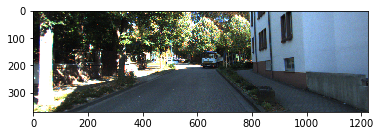

In [41]:
plt.imshow(camera_tensor[0])

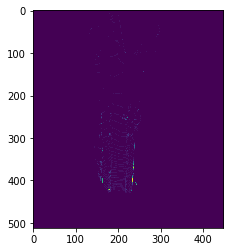

In [42]:
plt.imshow(np.clip(np.mean(lidar_tensor[0][:, :, :], 2), 0, 1)*255.)

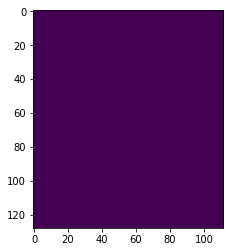

In [43]:
plt.imshow(label_tensor[0, :, :, 0, -1])
plt.show()

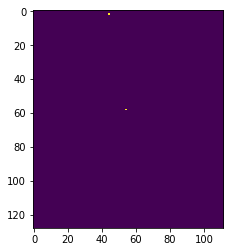

In [44]:
plt.imshow(label_tensor[0, :, :, 1, -1])
plt.show()

[[67.91574903  7.47278477 -0.721162  ]
 [67.80907639  9.05912509 -0.70551469]
 [71.44067667  9.30293037 -0.66498627]
 [71.54734931  7.71659005 -0.68063358]
 [67.89976143  7.45661978  0.80866937]
 [67.79308879  9.04296009  0.82431668]
 [71.42468908  9.28676538  0.8648451 ]
 [71.53136172  7.70042506  0.84919779]]
----
1.5300002
14.915855843764541
(16.781329528972506, 1.8654736852079647)
----
[[35.36200416  0.32399885 -0.98589539]
 [35.64640255  2.53563248 -0.95955399]
 [41.78551646  1.74552705 -0.90374548]
 [41.50111807 -0.46610658 -0.93008688]
 [35.33420874  0.29589501  1.67381089]
 [35.61860712  2.50752864  1.70015229]
 [41.75772104  1.71742321  1.75596079]
 [41.47332265 -0.49421042  1.7296194 ]]
----
2.6599998
25.932136192689732
(19.362480020383966, -6.5696561723057645)
----
[[ 10.51314414 177.63284582  17.50747281  26.17276833   8.89686405
   14.91585584   1.5038873 ]
 [234.37758424 218.71826202  19.96199924  44.40432911  12.52587498
   25.93213619   1.6989193 ]]



<Figure size 432x288 with 0 Axes>

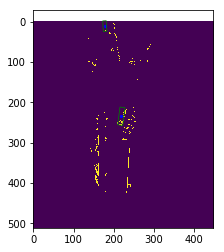

In [45]:
converted_points = convert_prediction_into_real_values(label_tensor[0, :, :, :, :], th=0.6)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=0.6)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
label_file_new = './'+ current_file + '.txt'
text_file = open(label_file_new, "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(label_file_new, 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

plt.clf()
fig,ax = plt.subplots(1)
img = np.clip(np.mean(lidar_tensor[0][:, :, 13:], 2)*255, 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    plt.scatter(y, x, s=5, c='b')
#     print(label_bev[i][6]*57.2958)
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
#     if i ==1:
#         break

print()


plt.show()

[[67.91574903  7.47278477 -0.721162  ]
 [67.80907639  9.05912509 -0.70551469]
 [71.44067667  9.30293037 -0.66498627]
 [71.54734931  7.71659005 -0.68063358]
 [67.89976143  7.45661978  0.80866937]
 [67.79308879  9.04296009  0.82431668]
 [71.42468908  9.28676538  0.8648451 ]
 [71.53136172  7.70042506  0.84919779]]
----
1.5300002
14.915855843764541
(16.781329528972506, 1.8654736852079647)
----
[[35.36200416  0.32399885 -0.98589539]
 [35.64640255  2.53563248 -0.95955399]
 [41.78551646  1.74552705 -0.90374548]
 [41.50111807 -0.46610658 -0.93008688]
 [35.33420874  0.29589501  1.67381089]
 [35.61860712  2.50752864  1.70015229]
 [41.75772104  1.71742321  1.75596079]
 [41.47332265 -0.49421042  1.7296194 ]]
----
2.6599998
25.932136192689732
(19.362480020383966, -6.5696561723057645)
----
[[ 10.51314414 177.63284582  17.50747281  26.17276833   8.89686405
   14.91585584   1.5038873 ]
 [234.37758424 218.71826202  19.96199924  44.40432911  12.52587498
   25.93213619   1.6989193 ]]



<Figure size 432x288 with 0 Axes>

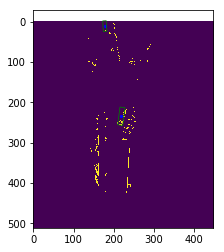

In [46]:
converted_points = convert_prediction_into_real_values(label_tensor[0, :, :, :, :], th=0.6)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=0.6)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
label_file_new = './'+ current_file + '.txt'
text_file = open(label_file_new, "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(label_file_new, 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

plt.clf()
fig,ax = plt.subplots(1)
img = np.clip(np.mean(lidar_tensor[0][:, :, 13:], 2)*255, 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    plt.scatter(y, x, s=5, c='b')
#     print(label_bev[i][6]*57.2958)
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
#     if i ==1:
#         break

print()


plt.show()

In [47]:
1.5/4, 15/40

(0.375, 0.375)

(40, 448)
26.172768330233417 8.896864050695118 14.915855843764541
44.40432911176266 12.525874977753292 25.932136192689732


<Figure size 432x288 with 0 Axes>

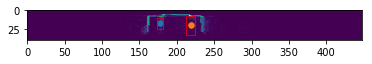

In [48]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_tensor[0].transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
print(img.shape)
ax.imshow(img)

for i in range(0, len(label_bev)):
    w = label_bev[i][3]
    h = label_bev[i][4] 
    d = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
    print(w, h, d)
    plt.scatter(y, z, s=30)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
    
    rect = patches.Rectangle((y-h/2, z-d/2),h, d, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


(40, 448)
26.172768330233417 8.896864050695118 14.915855843764541
44.40432911176266 12.525874977753292 25.932136192689732


<Figure size 432x288 with 0 Axes>

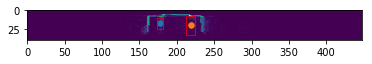

In [49]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_tensor[0].transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
print(img.shape)
ax.imshow(img)

for i in range(0, len(label_bev)):
    w = label_bev[i][3]
    h = label_bev[i][4] 
    d = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
    print(w, h, d)
    plt.scatter(y, z, s=30)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
    
    rect = patches.Rectangle((y-h/2, z-d/2),h, d, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [50]:
!cat $label_file_new 

Car -1 -1 -10 513 171 532 188 1.5300002 1.5899999 3.6400003 -8.366506584489384 1.4346052880763513 69.3960681823127 1.5038873 0.7310586
Car -1 -1 -10 559 144 619 199 2.6599998 2.23 6.1899996 -1.018465341600835 1.2836127200713054 38.28977155635845 1.6989193 0.7310586

In [171]:
!cat $label_file_new 

Car -1 -1 -10 548 180 567 198 1.5300002 1.5899999 3.6400003 -4.572588823367057 2.193394517367604 63.3300631724375 1.5038873 0.7310586
Car -1 -1 -10 651 158 706 225 2.6599998 2.23 6.1899996 3.1395481537964036 2.102636953513009 32.22311335889085 1.6989193 0.7310586

95.11102799999999
89.954406
89.954406



<Figure size 432x288 with 0 Axes>

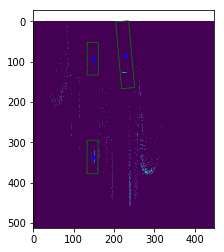

In [48]:
converted_points = convert_prediction_into_real_values(label_tensor[0, :, :, :, :], th=0.6)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=0.6)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
label_file_new = './'+ current_file + '.txt'
text_file = open(label_file_new, "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(label_file_new, 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

plt.clf()
fig,ax = plt.subplots(1)
ax.imshow(np.clip(np.mean(lidar_tensor[0][:, :, 9:], 2), 0, 1)*255.)

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    plt.scatter(y, x, s=10, c='b')
    print(label_bev[i][6]*57.2958)
    polygon = convert5Pointto8Point(y, x, w, h, label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()